In [6]:
import numpy as np

In [7]:
data_ibl = np.load("20240204_1426.npy")
time_ibl = data_ibl[:, 0]
omegaX_ibl = data_ibl[:, 1]
omegaY_ibl = data_ibl[:, 2] * (-1)
omegaZ_ibl = data_ibl[:, 3]

In [8]:
data_1 = np.load("05022024_1.npy")
time_1 = data_1[:, 0]
fi_1 = data_1[:, 1]
theta_1 = data_1[:, 2]
omega_1 = theta_1*3600

In [9]:
data_2 = np.load("05022024_2.npy")
time_2 = data_2[:, 0]
fi_2 = data_2[:, 1]
theta_2 = data_2[:, 2]
omega_2 = theta_2*3600

In [10]:
import matplotlib.pyplot as plt

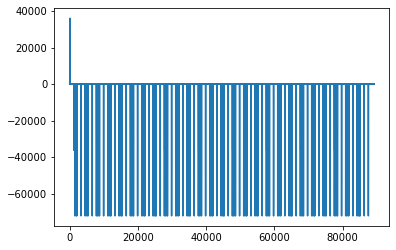

In [11]:
plt.plot(time_1, omega_1)

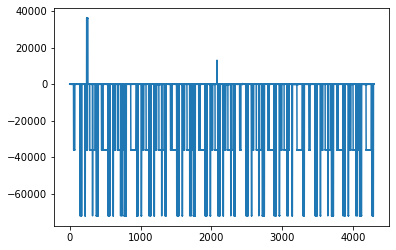

In [12]:
plt.plot(time_ibl, omegaY_ibl)

In [13]:
def cut_peaks(data, n):
    counter = 0
    in_peak = False

    for i in range(len(data)):
        if abs(data[i]) > 1000 and not in_peak:
            in_peak = True
            counter += 1
        elif in_peak and abs(data[i]) < 200:
            in_peak = False
            if counter == n:
                break
    print(data[i-20])
    if counter < n:
        print("Only ", counter, " peaks in data")
        return data
    else:
        return data[:i+1]

In [14]:
dataibl = cut_peaks(omegaY_ibl, 10)
timeibl = time_ibl[:len(dataibl)]

-3781.94157206


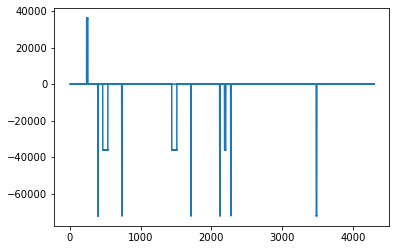

In [15]:
plt.figure()
plt.plot(timeibl, dataibl)
plt.show()

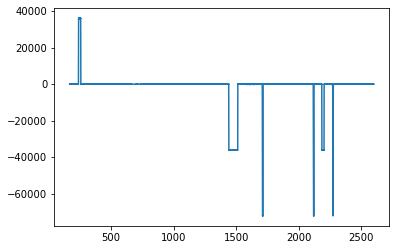

In [16]:
plt.figure()
plt.plot(timeibl[:len(dataibl)//2], dataibl[:len(dataibl)//2])
plt.show()

и как это понимать??? почему оно различается?

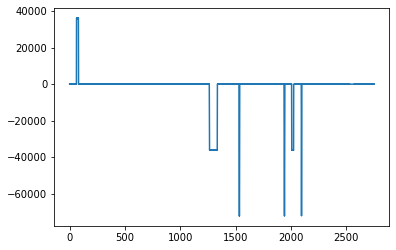

In [17]:
plt.figure()
plt.plot(time_1[:25000], omega_1[:25000])
plt.show()

In [31]:
def find_points(omega1, omega2, n_peaks, limit):
    counter = 0
    in_peak = False
    same_time = []
    index2 = 0 

    for i in range(len(omega1)):
        if abs(omega1[i]) > limit and not in_peak:
            in_peak = True
            counter += 1
            for j in range(index2, len(omega2), 1):
                if abs(omega2[j]) > limit:
                    same_time.append((i,j))
                    index2 = j
                    break
            
        elif in_peak and abs(omega1[i]) < limit:
            in_peak = False
            for j in range(index2, len(omega2), 1):
                if abs(omega2[j]) < limit:
                    same_time.append((i,j))
                    index2 = j
                    break
            if counter == n_peaks:
                break
    if counter < n_peaks:
        print("Only ", counter, " peaks in data")
    else:
        return same_time

In [34]:
points = find_points(omegaY_ibl, omega_1, 10, 500)
print(points, len(points))

[(14066, 556), (17861, 728), (254314, 11466), (268908, 12129), (308015, 13906), (309310, 13966), (389468, 17604), (390763, 17663), (403119, 18225), (406913, 18396), (420620, 19019), (421465, 19057), (661868, 29984), (664063, 30084), (904517, 41008), (906261, 41087), (918569, 41647), (933163, 42309), (972068, 44078), (973363, 44137)] 20


In [36]:
for i in range(len(points)):
    print(omegaY_ibl[points[i][0]], omega_1[points[i][1]])

539.7804193 3028.464
348.91362315 -35.352000000000004
-645.1723771 -3765.9960000000005
-465.84323294 -31.680000000000003
-540.78843943 -1127.52
-402.10454609 -9.216000000000001
-584.40927132 -1866.24
-379.93597371 53.136
-624.61389733 -3859.5600000000004
-482.84352796 0.36000000000000004
-611.604827 -1009.548
-342.74291861 -5.364
-584.99185547 -1330.3799999999999
-325.12289266 -20.628
-697.53986773 -3935.988
-413.32261362 -21.384
-649.96515123 -3078.936
-483.07110933 5.94
-574.02993953 -1518.084
-362.15537263 23.616


238.655 14066
257.63 17861
1439.895 254314
1512.865 268908
1708.4 308015
1714.875 309310
2115.665 389468
2122.14 390763
2183.92 403119
2202.89 406913
2271.425 420620
2275.65 421465
3477.665 661868
3488.64 664063
395.9427 904517
404.6627 906261
466.2027 918569
539.1727 933163
733.6977 972068
740.1727 973363


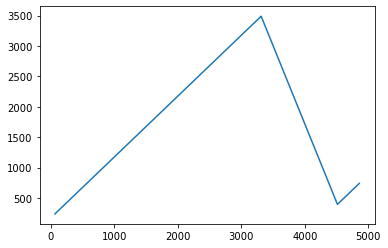

In [45]:
timeibl = []
time1 = []
for i in range(len(points)):
    #print(time_ibl[points[i][0]], time_1[points[i][1]])
    timeibl.append(time_ibl[points[i][0]])
    time1.append(time_1[points[i][1]])
    #print(time_1[points[i][1]], points[i][1])
    print(time_ibl[points[i][0]], points[i][0])
    
plt.figure()
plt.plot(time1, timeibl)
plt.show()

переполнение у времени блока оси timeibl после времени 4294.9650, это надо как-то отслеживать

In [49]:
for i in range(len(timeibl)-1):
    if abs(timeibl[i+1]-timeibl[i])>2000:
        for j in range(i+1, len(timeibl), 1):
            timeibl[j] += 4294.9650
        break
timeibl

[238.655,
 257.63,
 1439.895,
 1512.865,
 1708.4,
 1714.875,
 2115.665,
 2122.14,
 2183.92,
 2202.89,
 2271.425,
 2275.65,
 3477.665,
 3488.64,
 4690.9077,
 4699.6277,
 4761.1677,
 4834.1377,
 5028.6627,
 5035.1377]

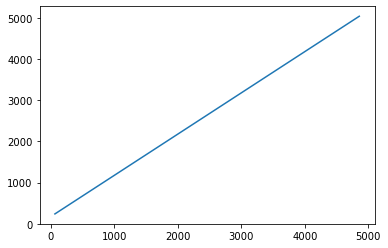

In [50]:
plt.plot(time1, timeibl)